In [23]:
# imports

import os
import re
import math
import random
from datetime import datetime
import numpy as np
from typing import Optional
from dotenv import load_dotenv
from openai import OpenAI
import anthropic
from huggingface_hub import login
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset, Dataset, DatasetDict
from concurrent.futures import ProcessPoolExecutor
from transformers import AutoTokenizer
from items_processing import ItemLoader, Item
import pickle

In [9]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [10]:
# initialize

openai = OpenAI()
claude = anthropic.Anthropic()
OPENAI_MODEL = "gpt-4o-mini"
CLAUDE_MODEL = "claude-3-5-sonnet-20240620"
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (osxkeychain).
Your token has been saved to /Users/ed/.cache/huggingface/token
Login successful


In [11]:
%matplotlib inline

In [12]:
# Constants
# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"

In [13]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [14]:
items = ItemLoader("Electronics").load(workers=8)

Loading dataset Electronics
Preparing data chunks... done.


100%|███████████████████████████████████████| 1611/1611 [02:37<00:00, 10.21it/s]


Completed loading Electronics with 443,473 datapoints in 2.7 mins


In [15]:
len(items)

443473

In [16]:
max(item.token_count for item in items)

179

In [ ]:
with open('items2.pkl', 'wb') as file:
    pickle.dump(items, file)

In [ ]:
with open('items2.pkl', 'rb') as file:
    items = pickle.load(file)

In [ ]:
len(items)

In [18]:
# Let's investigate:

print(f"There are {len(items):,} items with prices\n")
print(items[200000].prompt)

There are 443,473 items with prices

How much does this cost to the nearest dollar?

HAFURY Smart Watch Activity Fitness Tracker Watch, Compatible with Android and iOS Phone, Bluetooth Smartwatch with Heart Rate Monitor IP68 Waterproof, Step Sleep Tracker, for Men Women Kids, Black
★ Smart Watch for Android Phones&iPhone&Samsung This Android smartwatch is compatible with iOS 8.0 and above & Android 4.4 and above the cellphone. You can read notify of Calling, WhatsApp, Facebook, Wechat, SMS, App, Alarm, Target reaching, Calendar, Binding, and also hang up incoming calls. Soft and no easy dirty band offers your comfortable feelings. ★ Heart Rate Monitor Watch with Sleep Tracker Mens smart watch can automatically real-time heart rate monitor, sleep, steps, distance, calorie, active time to helps you optimally adjust your exercise intensity and enables a

Price is $20.00


Average length is 745.8 and highest length is 1,264



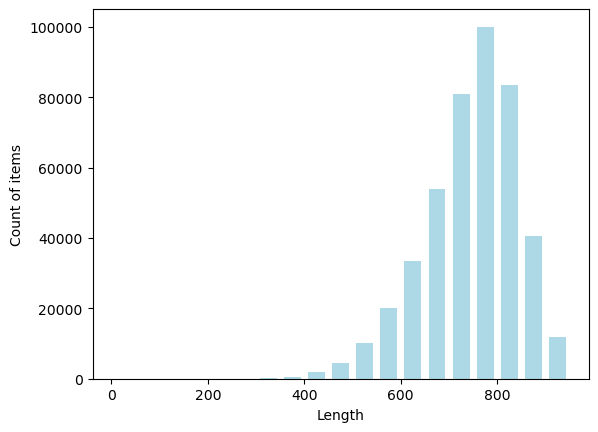

In [19]:
# Plot the distribution of character count

lengths = [len(item.prompt) for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Length')
ax.set_ylabel('Count of items');
_ = ax.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 1000, 50))

print(f"Average length is {sum(lengths)/len(lengths):,.1f} and highest length is {max(lengths):,}\n")

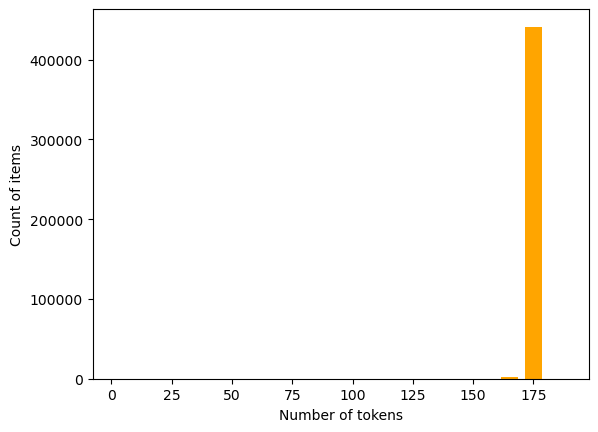

In [20]:
# Plot the distribution of tokens

token_counts = [item.token_count for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Count of items');
_ = ax.hist(token_counts, rwidth=0.7, color="orange", bins=range(0, 200, 10))

In [24]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [25]:
report(items[1])

How much does this cost to the nearest dollar?

NotoCity Compatible with Vivoactive 4 band 22mm Quick Release Silicone Bands/Garmin Darth Vader/First Avenger/Polar Vantage Smartwatch Sport Breathable Strap Replacement for Gear S3 Classic Watchband
☛NotoCity 22mm band is designed for Vivoactive 4 / Samsung Gear S3 Classic / S3 Frontier / Gear Live / Samsung Galaxy Watch 46mm / Huawei Watch GT / Tickwatch Pro / S2 / E2 / Pebble Classic / Time / Time Steel / Pebble 2 (Not Pebble steel) / Other Watches with 22mm lugs. ➹Wrist Size Small size fits wrist Large size fits wrist measure your wrist and make sure the size before you purchase. ➹No Tool Needed Quick Release Pin is easy

Price is $10.00
[17929, 374, 4228, 271, 7117, 374, 400, 605, 13, 410]
[' Pin', ' is', ' easy', '\n\n', 'Price', ' is', ' $', '10', '.', '00']


Average price is $72.29 and highest price is $999.49



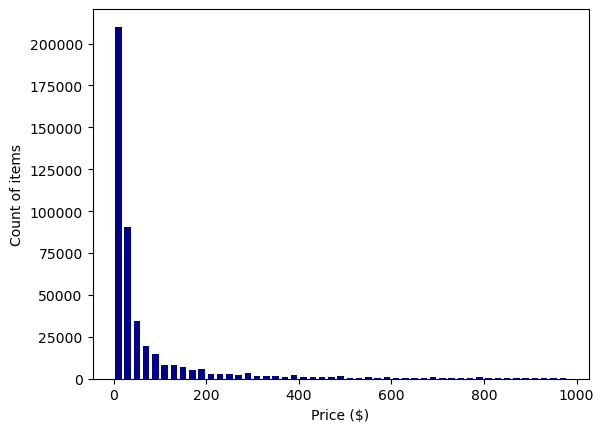

In [26]:
# Plot the distribution of prices

prices = [float(item.price) for item in items]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Count of items');
_ = ax.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 20))

print(f"Average price is ${sum(prices)/len(prices):.2f} and highest price is ${max(prices):,.2f}\n")

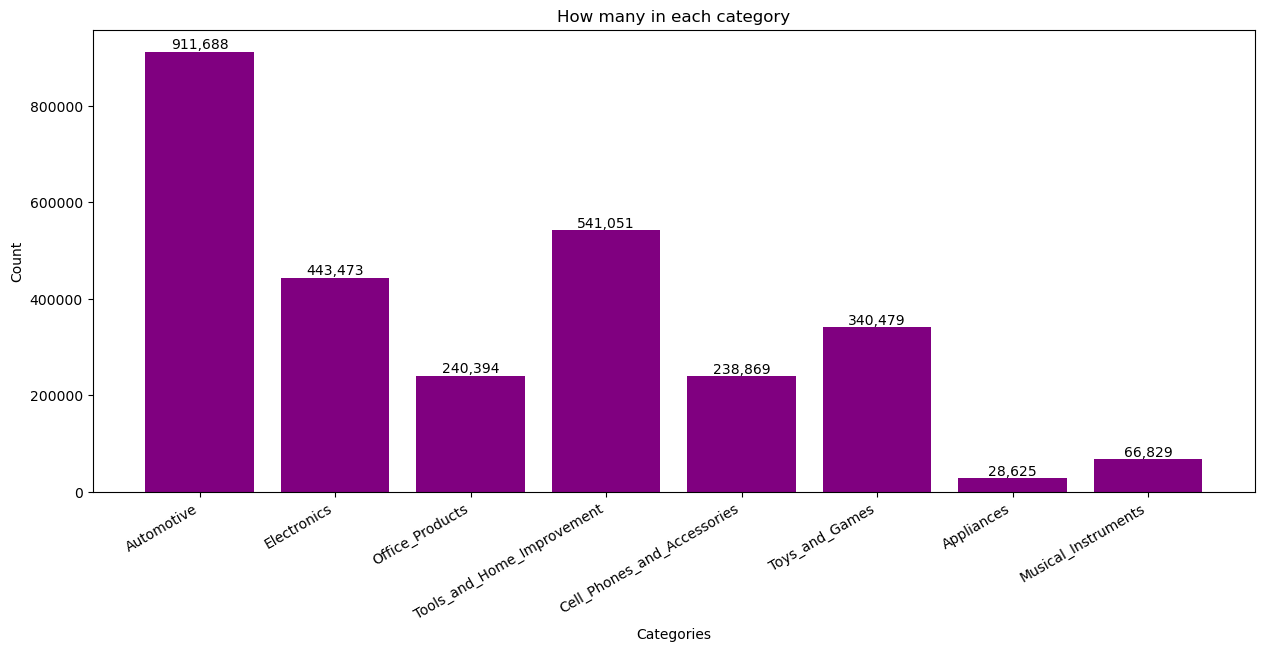

In [19]:
from collections import Counter
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="purple")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [20]:
from collections import defaultdict
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

print(f"\nMinimum: {min([len(slot) for slot in slots.values()]):,}")


Minimum: 7


In [22]:
np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)
len(sample)

408635

In [28]:
random.seed(42)
sorted_items = sorted(items, key=lambda item: item.price, reverse=True)
sample = sorted_items[:180_000]
sample += random.sample(sorted_items[180_000:250_000], k=22000)
len(sample)

202000

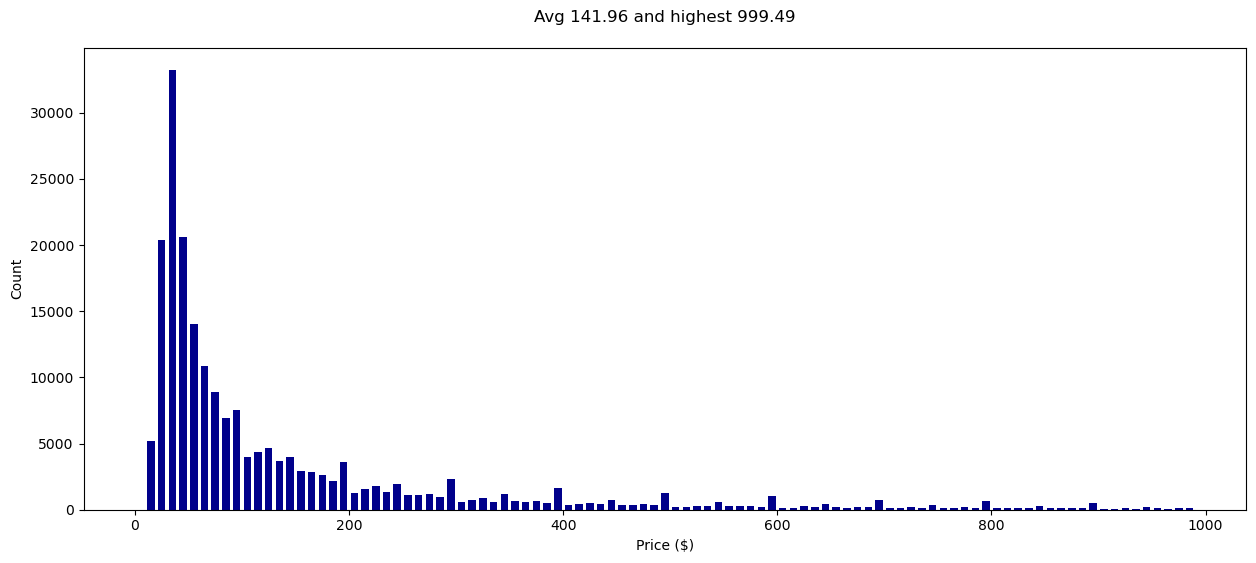

In [29]:
# Plot the distribution of prices

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

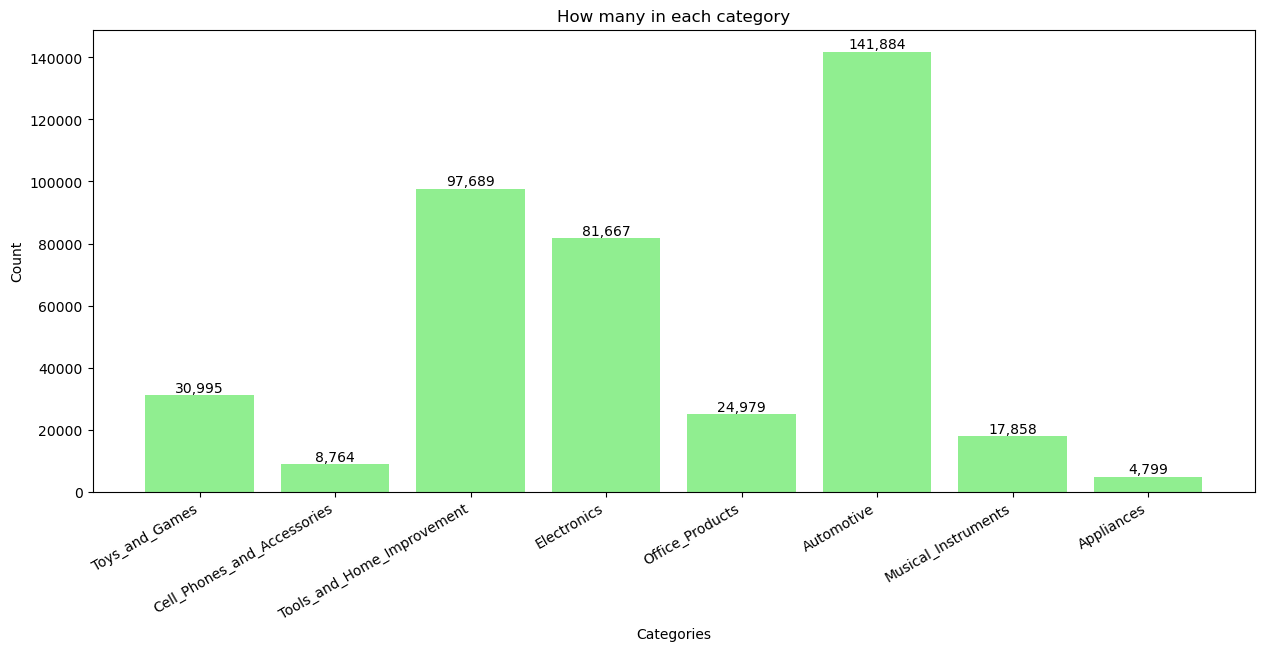

In [24]:
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

In [30]:
report(sample[100000])

How much does this cost to the nearest dollar?

RED WOLF Tailgate Handle w/Backup Camera Compatible with Dodge Ram 1500 2500 3500 Tailgate Door Rear View Reverse Backup Camera with RCA Plug Parking Guideline Available Waterproof
Fitment list Tailgate door handle with rear view backup camera replacement for Dodge Ram 1500, 2002 2004 2005 2006 2007 2009 Ram **NOTE** This is an aftermarket tailgate and camera, not OEM. Parking grid lines adjustable Fit for Dodge Ram 1500 reverse camera guideline with ON/OFF switch. Without cutting wiring harness required, control Dodge Ram 2500 parking guideline by removing or inserting the small black block. Clear HD vision Tailgate Handle Ram 1500 backup camera is made of advanced & professional technology with 0.

Price is $70.00
[449, 220, 15, 382, 7117, 374, 400, 2031, 13, 410]
[' with', ' ', '0', '.\n\n', 'Price', ' is', ' $', '70', '.', '00']


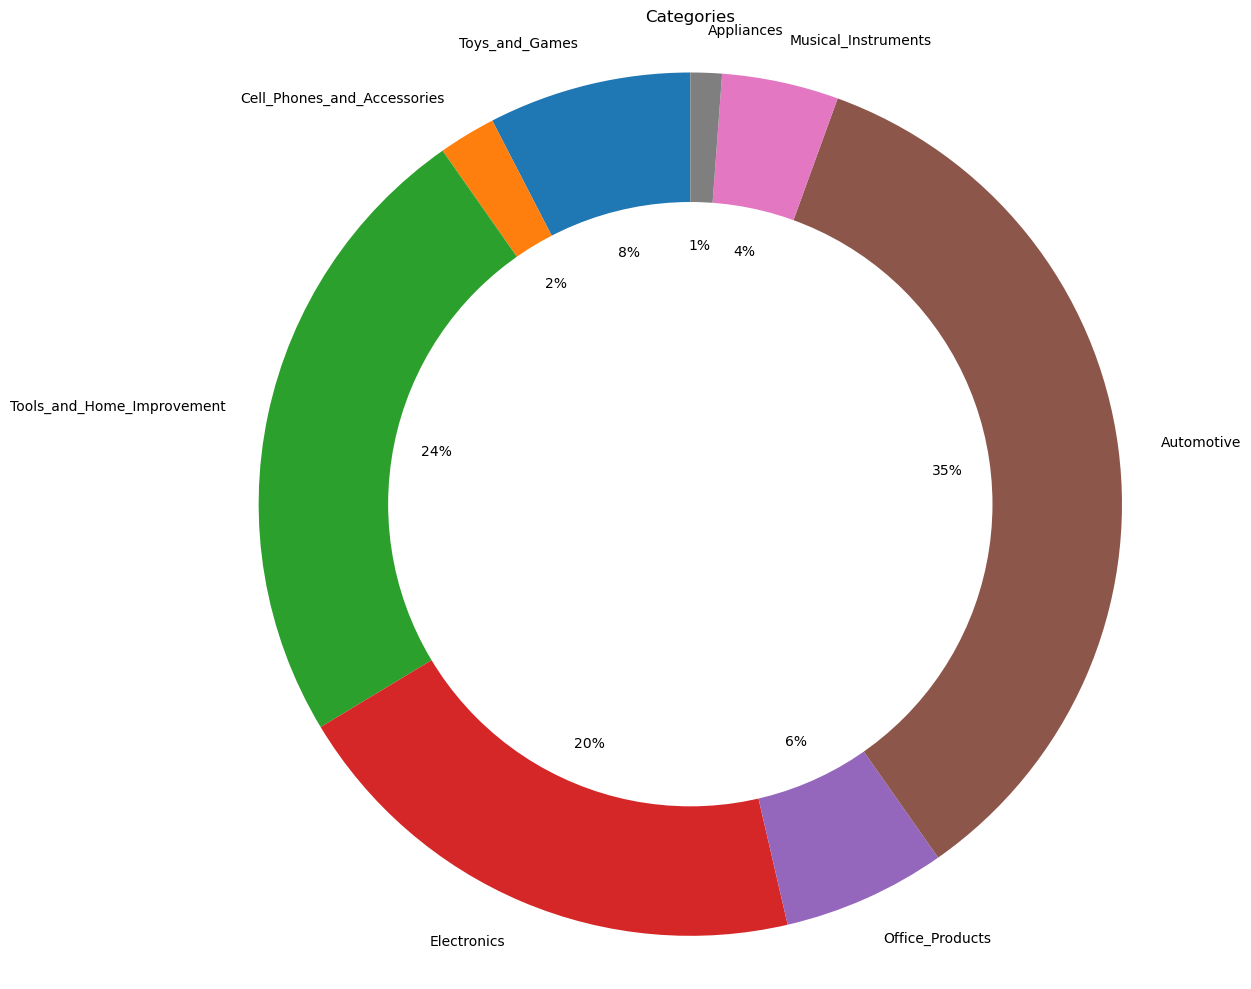

In [26]:
category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Customize the chart
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  

# Display the chart
plt.tight_layout()
plt.show()

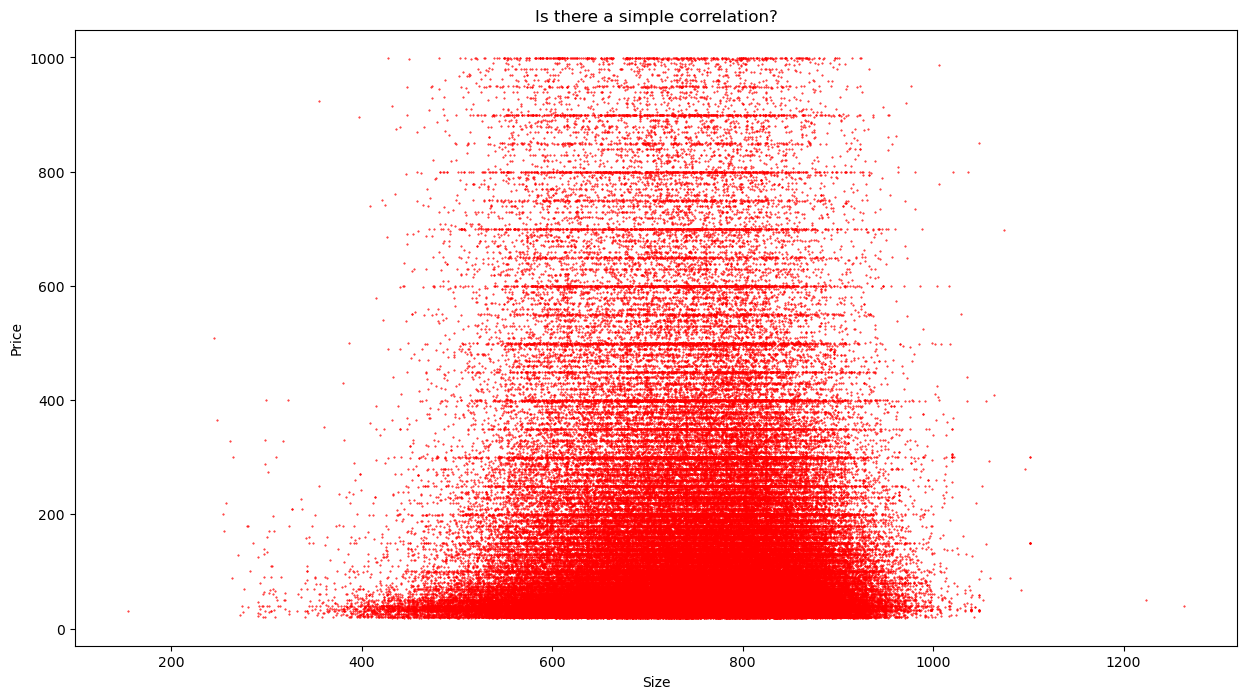

In [31]:
sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

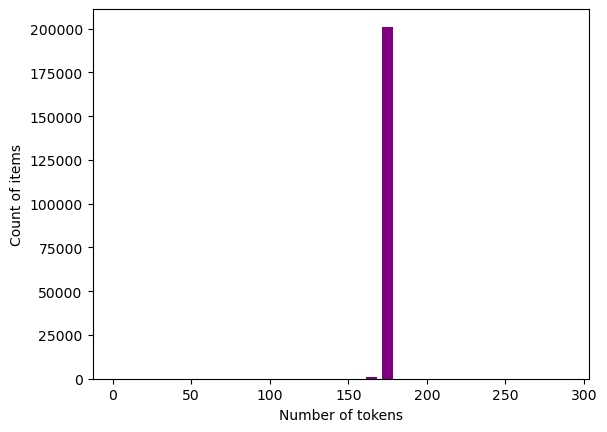

In [32]:
# Plot the distribution again to check it looks as expected

token_counts = [item.token_count for item in sample]
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Number of tokens')
ax.set_ylabel('Count of items');
_ = ax.hist(token_counts, rwidth=0.7, color="purple", bins=range(0, 300, 10))

In [33]:
report(sample[-2])

How much does this cost to the nearest dollar?

AuviPal USB-C Gigabit PoE Splitter, PoE to USB Type-C 5V/4A Max Power + Ethernet Data Adapter for Raspberry Pi 4 and More, Compliant | (AP-POE-USBC)
AuviPal Gigabit PoE Splitter is used for separating PoE signal into Ethernet data max) and USB-C power (DC 5V/4A max), ideal for providing faster & stable wired Ethernet and DC 5V Power for Raspberry Pi 4 simultaneously, Eliminate the need for a nearby AC outlet. What's more, It also can be used for providing constantly DC 5V power for any other USB Type-C devices, such as phone, tablet, camera etc which is placed far alway from AC outlet. ★★★

Price is $26.00
[13, 38334, 49617, 271, 7117, 374, 400, 1627, 13, 410]
['.', ' ★', '★★', '\n\n', 'Price', ' is', ' $', '26', '.', '00']


In [34]:
random.seed(42)
random.shuffle(sample)
train = sample[:200_000]
test = sample[200_000:202_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 200,000 items and test set of 2,000 items


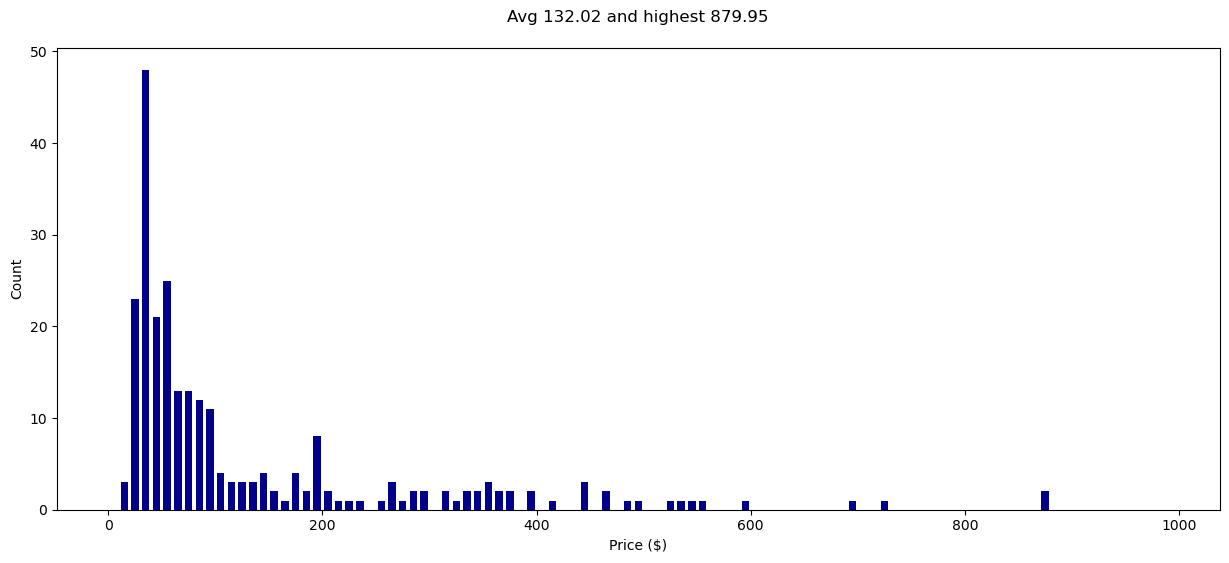

In [35]:
# Plot the distribution of prices

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

In [ ]:
# del items, slots
# import gc
# gc.collect()

In [ ]:
import csv
with open('test.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:200]:
        writer.writerow([t.title, t.details, 0])

In [ ]:
human_predictions = []
with open('human.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[2]))

In [34]:
average = sum(t.price for t in train)/len(train)
average

220.45738687487398

In [35]:
class TestRunner:

    def __init__(self, predictor, data, title, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint)
        truth = datapoint.price
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = RED if error>=40 else YELLOW if error>=20 else GREEN
        color_str = "red" if error>=40 else "yellow" if error>=20 else "green"
        title = datapoint.title if len(datapoint.title) <= 40 else datapoint.title[:40]+"..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color_str)
        print(f"{color}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = [e for e in self.errors if e<20]
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={len(hits)/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()
        return self

In [36]:
train_average = sum(t.price for t in train)/len(train)

def flat_predictor(item):
    return train_average

1: Guess: $220.46 Truth: $374.41 Error: $153.95 SLE: 0.28 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $220.46 Truth: $225.11 Error: $4.65 SLE: 0.00 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $220.46 Truth: $61.68 Error: $158.78 SLE: 1.59 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $220.46 Truth: $599.99 Error: $379.53 SLE: 1.00 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $220.46 Truth: $16.99 Error: $203.47 SLE: 6.30 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $220.46 Truth: $31.99 Error: $188.47 SLE: 3.63 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $220.46 Truth: $101.79 Error: $118.67 SLE: 0.59 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $220.46 Truth: $289.00 Error: $68.54 SLE: 0.07 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $220.46 Truth: $635.86 Error: $415.40 SLE: 1.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $220.46 Truth: $65.99 Error: $154.47 S

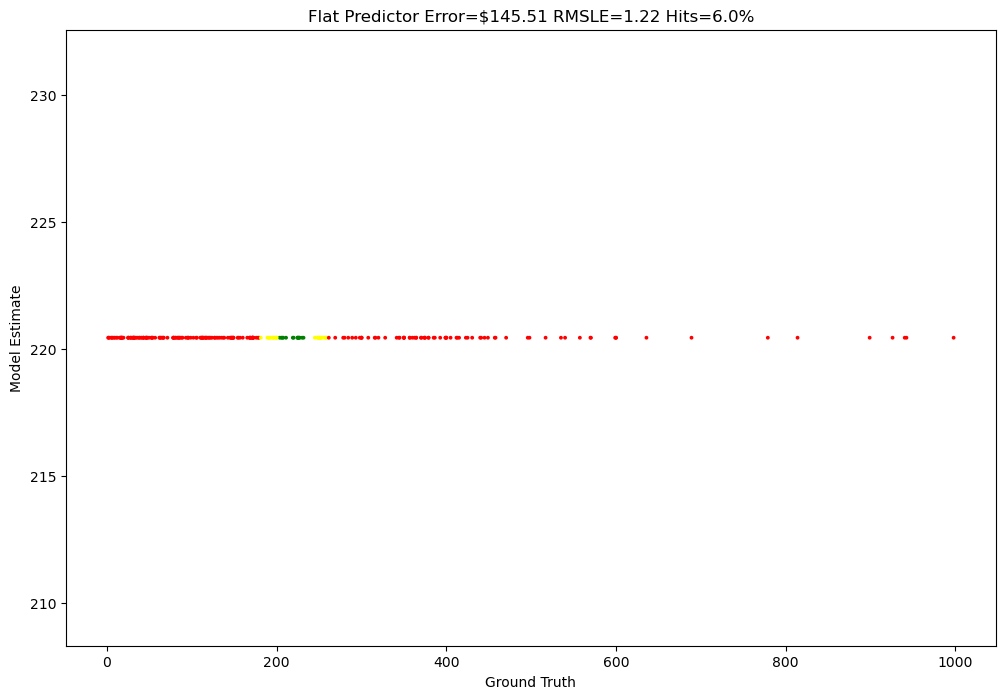

In [37]:
runner = TestRunner(flat_predictor, test, "Flat Predictor").run()

In [ ]:
human_predictions = []
with open('human.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[2]))

def human_predictor(item):
    index = test.index(item)
    if index==-1:
        raise ValueError("Index not found")
    return human_predictions[index]

In [ ]:
runner = TestRunner(human_predictor, test, "Human Predictor").run()

In [ ]:
stop = set(['the', 'and', 'for', 'is', 'to', 'this', 'with', 'a', 'of', 'your', 'are', 'in','from', 'you', 'or', 'an', 'on', 'by'])

def words(item):
  text = f"{item.title} {item.details}"
  text = re.sub(r'[\(\)\[\]\{\},\'"\- \s]+', ' ', text)
  words = text.strip().lower().split(' ')
  filtered = [word for word in words if word not in stop]
  return " ".join(filtered)

In [ ]:
documents = [words(item) for item in train]
from collections import Counter
count = Counter()
for doc in documents:
    ws = doc.split(" ")
    for w in ws:
        count[w]+=1
count.most_common(30)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
import numpy as np

np.random.seed(42)

labels = np.array([float(item.price) for item in train])

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(documents)

regressor = LinearRegression()
regressor.fit(X, labels)

In [ ]:
def linear_regression_predictor(item):
    np.random.seed(42)
    x = vectorizer.transform([words(item)])
    return max(regressor.predict(x)[0], 0)

In [ ]:
runner1 = TestRunner(linear_regression_predictor, test, "Linear Regression").run()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR

np.random.seed(42)

labels = np.array([float(item.price) for item in train])

vectorizer = TfidfVectorizer(max_features=20)
X = vectorizer.fit_transform(documents)

regressor = SVR(kernel='linear')
regressor.fit(X, labels)

In [ ]:
def svr_predictor(item):
    np.random.seed(42)
    x = vectorizer.transform([words(item)])
    return max(regressor.predict(x)[0], 0)

In [ ]:
runner2 = TestRunner(svr_predictor, test, "SVR Accuracy").run()

In [41]:
def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt}
    ]

In [42]:
def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [43]:
def gpt_predictor(item):
    response = openai.chat.completions.create(
        model=OPENAI_MODEL, #"gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=6
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $274.99 Truth: $374.41 Error: $99.42 SLE: 0.09 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $85.00 Truth: $225.11 Error: $140.11 SLE: 0.93 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $45.99 Truth: $61.68 Error: $15.69 SLE: 0.08 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $399.99 Truth: $599.99 Error: $200.00 SLE: 0.16 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $24.99 Truth: $16.99 Error: $8.00 SLE: 0.14 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $25.99 Truth: $31.99 Error: $6.00 SLE: 0.04 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $79.99 Truth: $101.79 Error: $21.80 SLE: 0.06 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $499.99 Truth: $635.86 Error: $135.87 SLE: 0.06 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $39.99 Truth: $65.99 Error: $26.00 SLE: 0.24 Ite

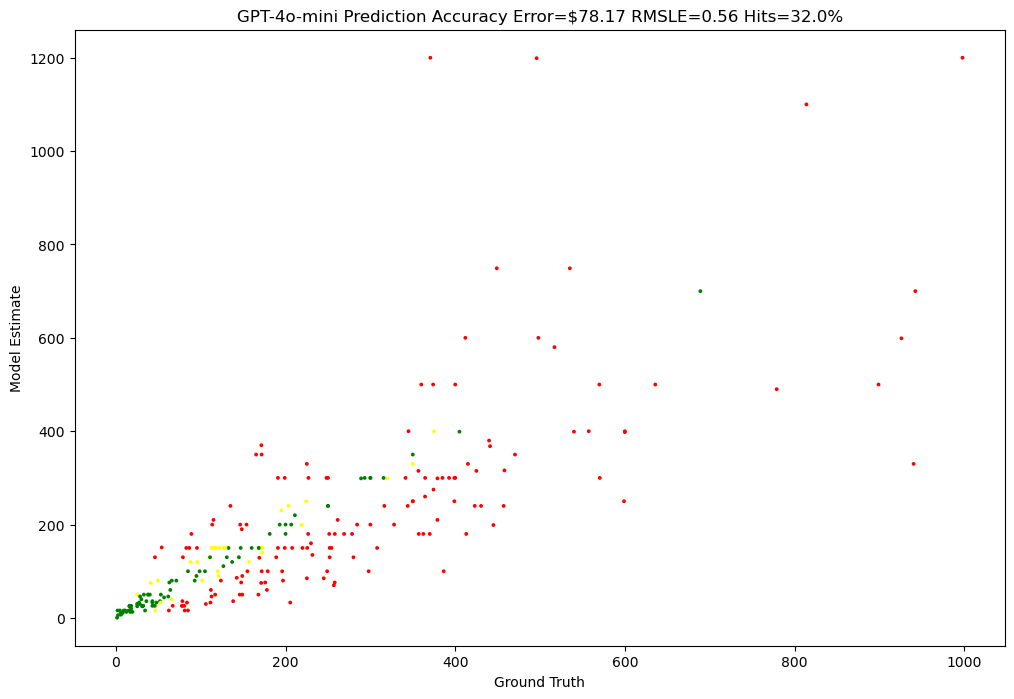

In [44]:
runner = TestRunner(gpt_predictor, test, "GPT-4o-mini Prediction Accuracy").run()

In [45]:
def frontier_predictor(item):
    response = openai.chat.completions.create(
        model="gpt-4o-2024-08-06", 
        messages=messages_for(item),
        seed=42,
        max_tokens=6
    )
    reply = response.choices[0].message.content
    return get_price(reply)

1: Guess: $209.95 Truth: $374.41 Error: $164.46 SLE: 0.33 Item: OEM AC Compressor w/A/C Repair Kit For F...
2: Guess: $74.99 Truth: $225.11 Error: $150.12 SLE: 1.19 Item: Motorcraft YB3125 Fan Clutch
3: Guess: $50.00 Truth: $61.68 Error: $11.68 SLE: 0.04 Item: Dorman 603-159 Front Washer Fluid Reserv...
4: Guess: $450.00 Truth: $599.99 Error: $149.99 SLE: 0.08 Item: HP Premium 17.3-inch HD Plus Touchscreen...
5: Guess: $15.99 Truth: $16.99 Error: $1.00 SLE: 0.00 Item: 5-Position Super Switch Pickup Selector ...
6: Guess: $15.99 Truth: $31.99 Error: $16.00 SLE: 0.44 Item: Horror Bookmarks, Resin Horror Bookmarks...
7: Guess: $129.99 Truth: $101.79 Error: $28.20 SLE: 0.06 Item: SK6241 - Stinger 4 Gauge 6000 Series Pow...
8: Guess: $299.00 Truth: $289.00 Error: $10.00 SLE: 0.00 Item: Godox ML60Bi LED Light Kit, Handheld LED...
9: Guess: $450.00 Truth: $635.86 Error: $185.86 SLE: 0.12 Item: Randall RG75DG3PLUS G3 Plus 100-Watt Com...
10: Guess: $59.99 Truth: $65.99 Error: $6.00 SLE: 0.01 I

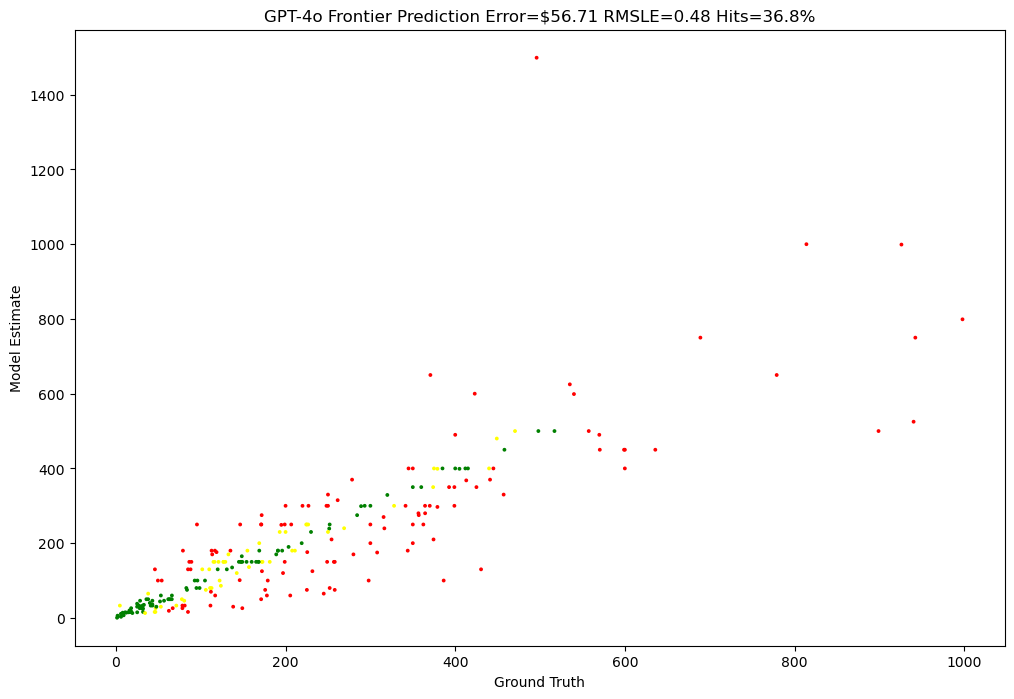

In [46]:
runner = TestRunner(frontier_predictor, test, "GPT-4o Frontier Prediction").run()

In [47]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [50]:
test_prompts[2]

'How much does this cost to the nearest dollar?\n\nDorman Front Washer Fluid Reservoir Compatible with Select Ford/Lincoln/Mercury Models\nThis washer fluid reservoir is designed to match the fit and function of the original equipment reservoir. It is engineered to withstand the stresses of underhood heat and engine vibration on specified vehicle makes, models, and years. This part is compatible with the following vehicles. Before purchasing, enter your vehicle trim in the garage tool to confirm fitment. Ford Explorer 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010 - Lincoln Aviator 2003, 2004, 2005 - Mercury Mountaineer 2002, 2003, 2004, 2005, \n\nPrice is $'

In [51]:
# Create a Dataset from the lists
train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [52]:
DATASET_NAME = "ed-donner/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ed-donner/pricer-data/commit/f38df5f756eafe7e331348b26a823e4d706f4a08', commit_message='Upload dataset', commit_description='', oid='f38df5f756eafe7e331348b26a823e4d706f4a08', pr_url=None, pr_revision=None, pr_num=None)